**Load the data**

In [1]:
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image.image_data_generator import ImageDataGenerator
from tensorflow.keras import Model,Sequential
from tensorflow.keras import layers
from keras import models
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import os
import cv2
import shutil

In [2]:
print(tf.__file__)

/opt/conda/lib/python3.7/site-packages/tensorflow/__init__.py


In [3]:
import h5py

f = h5py.File('../input/lungnodemalignancy/all_patches.hdf5','r')
print(list(f.keys()))

ct_slices = f['ct_slices']
slice_class = f['slice_class']

ct_slices = np.array(ct_slices)
slice_class = np.array(slice_class)

print(ct_slices.shape)
print(slice_class.shape)

['ct_slices', 'slice_class']
(6691, 64, 64)
(6691, 1)


Split training dataset and validation dataset

In [44]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

ct_slices = ct_slices.reshape(6691,64,64,1)

X_train, X_test, y_train, y_test = train_test_split(ct_slices, slice_class, test_size=0.33, random_state=42)

y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4482, 64, 64, 1)
(4482, 2)
(2209, 64, 64, 1)


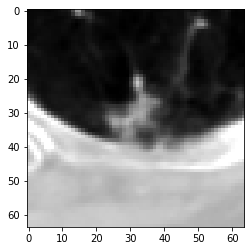

In [5]:

import pylab
ct_slices = np.clip(ct_slices, -1000,320)

pylab.imshow(ct_slices[5], cmap=pylab.cm.gray)  
pylab.show()

/opt/conda/lib/python3.7/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/opt/conda/lib/python3.7/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/opt/conda/lib/python3.7/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/opt/conda/lib/python3.7/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You c

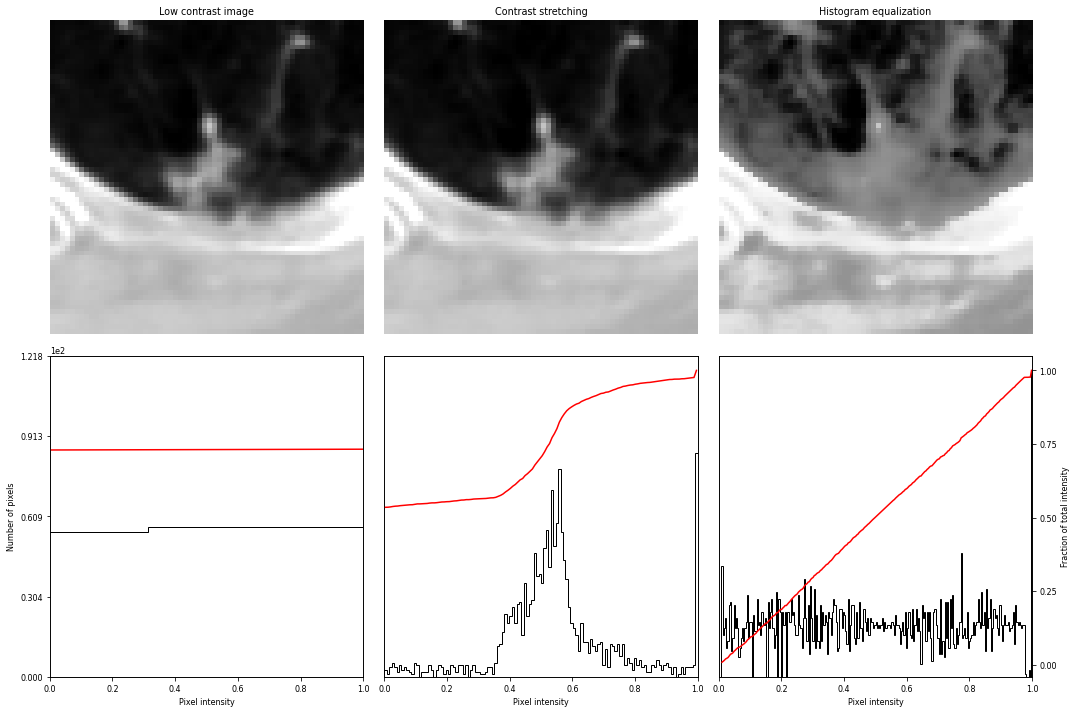

In [6]:
from skimage import data, img_as_float
from skimage import exposure

# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure

def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf
# Load an example image from cifar10 dataset
#img = images[0]

# Set font size for images
matplotlib.rcParams['font.size'] = 8

img = ct_slices[5] 
# img = ((img-np.min(img))/(np.max(img)-np.min(img)))

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Histogram Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
# img_adapteq = exposure.equalize_adapthist(img)

#### Everything below here is just to create the plot/graphs ####

# Display results
fig = plt.figure(figsize=(15, 10)) 
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 3, 1)
for i in range(1, 3):
    axes[0, i] = fig.add_subplot(2, 3, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 3):
    axes[1, i] = fig.add_subplot(2, 3, 4+i)
    
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

# ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
# ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

Build CNN with Keras

In [7]:
from keras.applications.resnet50 import ResNet50
#from keras.applications import MobileNetV2
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Input
from keras import backend as K
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import numpy as np
import skimage.transform
import keras

#conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(64,64,1)))
# model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(MyCustomLayer(32,use_bias = False))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# # model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
# # model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))


# model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
# model.add(Dense(64, activation = 'relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

history = model.fit(
        X_train,y_train,
        batch_size=100,
        epochs=100,
        validation_data=(X_test, y_test))

Epoch 1/100
45/45 [==============================] - 11s 142ms/step - loss: 14.6748 - accuracy: 0.5287 - val_loss: 0.6955 - val_accuracy: 0.5075
Epoch 2/100
45/45 [==============================] - 5s 116ms/step - loss: 0.6659 - accuracy: 0.6134 - val_loss: 0.6505 - val_accuracy: 0.6356
Epoch 3/100
45/45 [==============================] - 5s 116ms/step - loss: 0.6378 - accuracy: 0.6532 - val_loss: 0.6440 - val_accuracy: 0.6636
Epoch 4/100
45/45 [==============================] - 5s 116ms/step - loss: 0.6157 - accuracy: 0.6711 - val_loss: 0.6113 - val_accuracy: 0.6632
Epoch 5/100
45/45 [==============================] - 5s 116ms/step - loss: 0.6102 - accuracy: 0.6794 - val_loss: 0.6445 - val_accuracy: 0.6483
Epoch 6/100
45/45 [==============================] - 5s 117ms/step - loss: 0.5971 - accuracy: 0.6832 - val_loss: 0.5905 - val_accuracy: 0.6790
Epoch 7/100
45/45 [==============================] - 5s 116ms/step - loss: 0.5655 - accuracy: 0.7110 - val_loss: 0.5858 - val_accuracy: 0.68

In [8]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

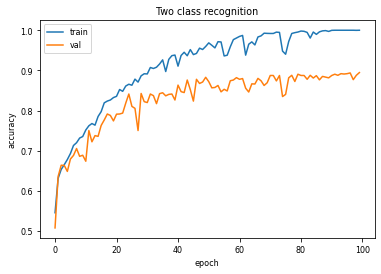

In [9]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Two class recognition')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Create CAM(heating map)

In [10]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [11]:
def normalization(image):
    return (image - image.min())/(image.max() - image.min())

def gray_to_redblue(image):
    R,G,B = image[:,:,0], image[:,:,1], image[:,:,2]
    #grey = sum(pixel) // len(pixel)
    redvalue = 1 - R  # "darkness"
    bluevalue = B  # "brightness"
    image[:,:,0] = B
    image[:,:,1] = 0
    image[:,:,2] = 1-R
    return image# + alpha



(16, 16)
(64, 64, 3)
(64, 64, 3)


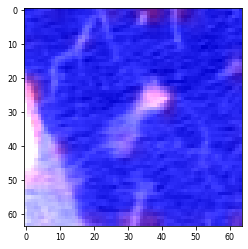

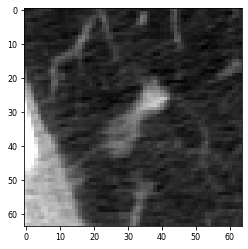

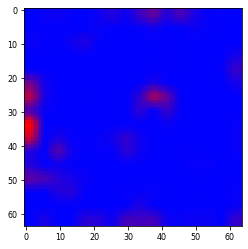

In [12]:
import cv2
from PIL import Image
from sklearn import preprocessing
import tensorflow as tf

def generate_CAM(image,layer):
    img_array = np.reshape(image,(1,64,64,1))
    preds = model.predict(img_array)
    H5py_cam = make_gradcam_heatmap(img_array,model,layer)
    print(H5py_cam.shape)
    heatmap = cv2.resize(H5py_cam,(img_array.shape[1],img_array.shape[2]))
    img_map = np.reshape(img_array,(64,64))
    heatmap = normalization(heatmap)
    img_map = normalization(img_map)
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_GRAY2RGB)
    img_map = cv2.cvtColor(img_map,cv2.COLOR_GRAY2RGB)
    heatmap = gray_to_redblue(heatmap)
    #heatmap = cv2.cvtColor(heatmap,cv2.COLOR_GRAY2RGB)
    print(heatmap.shape)
    print(img_map.shape)
    combination = heatmap * 0.8 + img_map * 1

    plt.imshow(combination)
    plt.show()
    
    pylab.imshow(img_map, cmap=pylab.cm.gray)  
    pylab.show()
    pylab.imshow(heatmap, cmap=pylab.cm.jet)  
    pylab.show()
    
generate_CAM(ct_slices[378],'max_pooling2d_1')
    

In [13]:
from sklearn.metrics import classification_report
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1),
                      y_pred))


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1358
           1       0.85      0.87      0.86       851

    accuracy                           0.89      2209
   macro avg       0.88      0.89      0.88      2209
weighted avg       0.89      0.89      0.89      2209



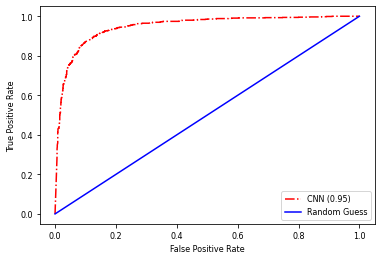

In [14]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()

Testing the model

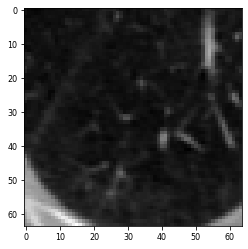

True class of the Image : [1. 0.]
Predicted class of the Image : [1. 0.]


In [43]:
index = 1002

pylab.imshow(X_test[index], cmap=pylab.cm.gray)  
pylab.show()

print("True class of the Image : " + str(y_test[index]))
img_array = np.reshape(X_test[index], (1,64,64,1))
preds = model.predict(img_array)
print("Predicted class of the Image : " + str(y_test[index]))